In [ ]:
!pip install Sastrawi

import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Libraries untuk NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Libraries untuk preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [ ]:
# =============================================================================
# STEP 1: DATA LOADING DAN INITIAL EXPLORATION
# =============================================================================

def load_and_explore_data(file_path):
    """
    Load dataset dan lakukan exploratory data analysis
    """
    print("="*60)
    print("STEP 1: LOADING DAN EXPLORING DATA")
    print("="*60)

    # Load data
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Basic info
    print("\n--- BASIC INFO ---")
    print(df.head())
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")

    # Statistics untuk ulasan
    if 'Customer Review' in df.columns:
        review_lengths = df['Customer Review'].str.len()
        print(f"\n--- REVIEW STATISTICS ---")
        print(f"Average review length: {review_lengths.mean():.2f}")
        print(f"Min review length: {review_lengths.min()}")
        print(f"Max review length: {review_lengths.max()}")

        # Distribusi rating
        print(f"\n--- RATING DISTRIBUTION ---")
        print(df['Customer Rating'].value_counts().sort_index())

    return df

In [ ]:
# =============================================================================
# STEP 2: TEXT PREPROCESSING UNTUK BAHASA INDONESIA
# =============================================================================

def create_preprocessing_pipeline():
    """
    Membuat pipeline preprocessing untuk bahasa Indonesia
    """
    print("\n" + "="*60)
    print("STEP 2: MEMBUAT PREPROCESSING PIPELINE")
    print("="*60)

    # Inisialisasi Sastrawi
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    stop_factory = StopWordRemoverFactory()
    stopword_remover = stop_factory.create_stop_word_remover()

    # Dictionary untuk normalisasi slang Indonesia
    slang_dict = {
        'bgus': 'bagus', 'brng': 'barang', 'kpn': 'kapan', 'gmn': 'gimana',
        'tp': 'tapi', 'yg': 'yang', 'dgn': 'dengan', 'utk': 'untuk',
        'krn': 'karena', 'udh': 'sudah', 'blm': 'belum', 'org': 'orang',
        'smg': 'semoga', 'thx': 'terima kasih', 'tks': 'terima kasih',
        'mantap': 'mantap', 'rekomended': 'direkomendasikan', 'recommended': 'direkomendasikan',
        'bgt': 'banget', 'bener': 'benar', 'uda': 'sudah', 'udah': 'sudah',
        'ga': 'tidak', 'gak': 'tidak', 'gk': 'tidak', 'nggak': 'tidak'
    }

    def preprocess_text(text):
        """
        Preprocessing untuk text bahasa Indonesia
        """
        if pd.isna(text):
            return ""

        # Convert to string dan lowercase
        text = str(text).lower()

        # Remove URLs, email, mentions
        text = re.sub(r'http\S+|www\S+|@\w+|\S+@\S+', '', text)

        # Remove angka
        text = re.sub(r'\d+', '', text)

        # Remove karakter khusus, keep only letters dan spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Normalisasi slang
        words = text.split()
        words = [slang_dict.get(word, word) for word in words]
        text = ' '.join(words)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Stemming
        text = stemmer.stem(text)

        # Remove stopwords
        text = stopword_remover.remove(text)

        return text

    print("Preprocessing pipeline created successfully!")
    return preprocess_text

In [ ]:
# =============================================================================
# STEP 3: RULE-BASED LABELING UNTUK SDG 12 CLASSIFICATION
# =============================================================================

def create_sustainability_labeling_system():
    """
    Membuat sistem labeling berbasis rule untuk aspek sustainability
    """
    print("\n" + "="*60)
    print("STEP 3: MEMBUAT RULE-BASED LABELING SYSTEM")
    print("="*60)

    # Dictionary kata kunci untuk setiap kategori SDG 12
    sustainability_keywords = {
        'kemasan_boros': [
            'plastik', 'bubble wrap', 'kemasan', 'packing', 'bungkus',
            'pembungkus', 'sampah', 'boros kemasan', 'kemasan berlebihan',
            'terlalu banyak plastik', 'packaging boros', 'kemasan tidak perlu',
            'banyak sampah', 'limbah kemasan', 'kemasan dobel'
        ],

        'produk_tidak_tahan_lama': [
            'cepat rusak', 'tidak tahan lama', 'mudah pecah', 'gampang rusak',
            'tidak awet', 'kualitas jelek', 'murahan', 'abal-abal',
            'cepat panas', 'daya tahan rendah', 'mudah patah', 'rapuh',
            'tidak berkualitas', 'jelek', 'buruk', 'mengecewakan',
            'rusak cepat', 'patah', 'pecah', 'lemah'
        ],

        'produk_awet_berkualitas': [
            'tahan lama', 'awet', 'kuat', 'kokoh', 'berkualitas',
            'bagus banget', 'recommended', 'worth it', 'puas banget',
            'tidak mengecewakan', 'investasi bagus', 'durable',
            'solid', 'premium', 'excellent', 'amazing', 'fantastic',
            'perfect', 'mantap', 'jos', 'top', 'berkualitas tinggi'
        ]
    }

    def classify_review_sustainability(review_text):
        """
        Mengklasifikasikan ulasan berdasarkan aspek sustainability
        """
        if pd.isna(review_text) or review_text == "":
            return 'netral'

        text = str(review_text).lower()
        scores = {'kemasan_boros': 0, 'produk_tidak_tahan_lama': 0, 'produk_awet_berkualitas': 0}

        # Hitung score untuk setiap kategori
        for category, keywords in sustainability_keywords.items():
            for keyword in keywords:
                if keyword in text:
                    scores[category] += 1

        # Tentukan label berdasarkan score tertinggi
        if max(scores.values()) == 0:
            return 'netral'
        else:
            return max(scores, key=scores.get)

    print("Rule-based labeling system created!")
    print("Categories:")
    for category, keywords in sustainability_keywords.items():
        print(f"  {category}: {len(keywords)} keywords")

    return classify_review_sustainability, sustainability_keywords

In [ ]:
# =============================================================================
# STEP 4: DATA PREPARATION DAN LABELING
# =============================================================================

def prepare_and_label_data(df, preprocess_func, labeling_func):
    """
    Mempersiapkan data dengan preprocessing dan labeling
    """
    print("\n" + "="*60)
    print("STEP 4: DATA PREPARATION DAN LABELING")
    print("="*60)

    # Ambil kolom yang diperlukan
    if 'Customer Review' in df.columns:
        review_col = 'Customer Review'
    else:
        review_col = df.columns[0]  # Fallback ke kolom pertama

    # Buat dataframe baru
    data = df[[review_col]].copy()
    data = data.rename(columns={review_col: 'review_text'})

    # Remove missing values
    data = data.dropna(subset=['review_text'])

    # Preprocessing text
    print("Preprocessing text...")
    data['processed_text'] = data['review_text'].apply(preprocess_func)

    # Remove empty processed texts
    data = data[data['processed_text'].str.len() > 0]

    # Labeling berdasarkan sustainability
    print("Applying rule-based labeling...")
    data['sustainability_label'] = data['review_text'].apply(labeling_func)

    # Distribusi label
    print("\n--- LABEL DISTRIBUTION ---")
    label_counts = data['sustainability_label'].value_counts()
    print(label_counts)

    # Visualisasi distribusi
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar')
    plt.title('Distribusi Label Sustainability')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return data

In [ ]:
# =============================================================================
# STEP 5: DATA BALANCING (FIXED VERSION)
# =============================================================================

def balance_dataset(data, strategy='auto', random_state=42):
    """
    Melakukan balancing dataset dengan berbagai strategi
    """
    print("\n" + "="*60)
    print("STEP 5: DATA BALANCING")
    print("="*60)

    # Cek distribusi awal
    print("Distribusi sebelum balancing:")
    label_counts = data['sustainability_label'].value_counts()
    print(label_counts)

    # Siapkan data untuk balancing
    X = data[['processed_text']]
    y = data['sustainability_label']

    # Tentukan strategi balancing
    if strategy == 'auto':
        # Pilih strategi berdasarkan distribusi data
        max_samples = label_counts.max()
        min_samples = label_counts.min()
        ratio = max_samples / min_samples

        if ratio > 10:
            # Jika imbalance sangat tinggi, gunakan kombinasi under dan over sampling
            print("Using combined over and under sampling (SMOTEENN)")
            try:
                sampler = SMOTEENN(random_state=random_state)
            except:
                # Fallback jika SMOTEENN tidak tersedia
                print("SMOTEENN not available, using RandomOverSampler")
                target_samples = min_samples * 3  # Moderate oversampling
                sampling_strategy = {}
                for label in label_counts.index:
                    if label_counts[label] < target_samples:
                        sampling_strategy[label] = target_samples
                sampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)
        elif ratio > 3:
            # Moderate imbalance, gunakan oversampling
            print("Using RandomOverSampler")
            target_samples = int(max_samples * 0.7)  # Target 70% dari kelas mayoritas
            sampling_strategy = {}
            for label in label_counts.index:
                if label_counts[label] < target_samples:
                    sampling_strategy[label] = target_samples
            sampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)
        else:
            # Low imbalance, tidak perlu balancing
            print("Low imbalance detected, skipping balancing")
            return data

    elif strategy == 'oversample':
        # Oversampling ke jumlah kelas mayoritas
        print("Using RandomOverSampler")
        max_samples = label_counts.max()
        sampling_strategy = {}
        for label in label_counts.index:
            sampling_strategy[label] = max_samples
        sampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)

    elif strategy == 'undersample':
        # Undersampling ke jumlah kelas minoritas
        print("Using RandomUnderSampler")
        min_samples = label_counts.min()
        sampling_strategy = {}
        for label in label_counts.index:
            sampling_strategy[label] = min_samples
        sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)

    else:
        print("Invalid strategy, returning original data")
        return data

    # Apply sampling
    try:
        # Convert text to numerical representation for sampling
        X_encoded = pd.get_dummies(X['processed_text'].astype('category'))
        X_resampled, y_resampled = sampler.fit_resample(X_encoded, y)

        # Create balanced dataframe
        # Since we can't directly map back the encoded features to original text
        # We'll use a different approach: sample indices

        # Get indices for each class after resampling
        unique_labels = y.unique()
        balanced_indices = []

        for label in unique_labels:
            label_indices = data[data['sustainability_label'] == label].index.tolist()
            target_count = sum(y_resampled == label)

            if len(label_indices) >= target_count:
                # Undersample
                selected_indices = np.random.choice(label_indices, target_count, replace=False)
            else:
                # Oversample
                selected_indices = np.random.choice(label_indices, target_count, replace=True)

            balanced_indices.extend(selected_indices)

        # Create balanced dataset
        balanced_data = data.loc[balanced_indices].copy()
        balanced_data = balanced_data.reset_index(drop=True)

    except Exception as e:
        print(f"Error during resampling: {e}")
        print("Using simple random sampling approach...")

        # Simple approach: sample equal number from each class
        min_samples = label_counts.min()
        target_samples = min(min_samples * 2, 1000)  # Cap at 1000 samples per class

        balanced_dfs = []
        for label in label_counts.index:
            label_data = data[data['sustainability_label'] == label]
            if len(label_data) >= target_samples:
                sampled_data = label_data.sample(n=target_samples, random_state=random_state)
            else:
                sampled_data = label_data.sample(n=target_samples, replace=True, random_state=random_state)
            balanced_dfs.append(sampled_data)

        balanced_data = pd.concat(balanced_dfs, ignore_index=True)
        balanced_data = balanced_data.sample(frac=1, random_state=random_state).reset_index(drop=True)

    print("\nDistribusi setelah balancing:")
    print(balanced_data['sustainability_label'].value_counts())

    return balanced_data

In [ ]:
# =============================================================================
# STEP 6: FEATURE ENGINEERING DENGAN TF-IDF
# =============================================================================

def create_tfidf_features(texts, max_features=3000):
    """
    Membuat fitur TF-IDF dari teks
    """
    print("\n" + "="*60)
    print("STEP 6: FEATURE ENGINEERING DENGAN TF-IDF")
    print("="*60)

    # Konfigurasi TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),  # Unigrams dan bigrams
        min_df=2,           # Minimum document frequency
        max_df=0.95,        # Maximum document frequency
        sublinear_tf=True   # Apply sublinear tf scaling
    )

    # Fit dan transform
    print("Creating TF-IDF features...")
    tfidf_matrix = vectorizer.fit_transform(texts)

    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

    # Tampilkan top features
    feature_names = vectorizer.get_feature_names_out()
    print(f"\nSample features: {feature_names[:20]}")

    return tfidf_matrix, vectorizer

In [ ]:
# =============================================================================
# STEP 7: MODEL TRAINING DAN COMPARISON
# =============================================================================

def train_and_compare_models(X_train, X_test, y_train, y_test):
    """
    Melatih berbagai model dan membandingkan performanya
    """
    print("\n" + "="*60)
    print("STEP 7: MODEL TRAINING DAN COMPARISON")
    print("="*60)

    # Definisi models
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Linear SVC': LinearSVC(random_state=42, max_iter=1000)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Training
        model.fit(X_train, y_train)

        # Prediction
        y_pred = model.predict(X_test)

        # Evaluation
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_macro': report['macro avg']['f1-score'],
            'f1_weighted': report['weighted avg']['f1-score'],
            'classification_report': classification_report(y_test, y_pred)
        }

        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score (macro): {report['macro avg']['f1-score']:.4f}")

    # Hyperparameter tuning untuk Naive Bayes (model terbaik)
    print("\n--- HYPERPARAMETER TUNING NAIVE BAYES ---")
    param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

    nb = MultinomialNB()
    grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Evaluasi model terbaik
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test)

    results['Naive Bayes (Tuned)'] = {
        'model': best_model,
        'accuracy': accuracy_score(y_test, y_pred_best),
        'classification_report': classification_report(y_test, y_pred_best)
    }

    return results, best_model

In [ ]:
# =============================================================================
# STEP 8: MODEL EVALUATION DAN VISUALIZATION
# =============================================================================

def evaluate_and_visualize_model(model, X_test, y_test, class_names):
    """
    Evaluasi model dan visualisasi hasil
    """
    print("\n" + "="*60)
    print("STEP 8: MODEL EVALUATION DAN VISUALIZATION")
    print("="*60)

    # Prediction
    y_pred = model.predict(X_test)

    # Classification report
    print("--- CLASSIFICATION REPORT ---")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    print("\n--- PER-CLASS ACCURACY ---")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_accuracy[i]:.4f}")

    return cm

In [ ]:
# =============================================================================
# STEP 9: FEATURE IMPORTANCE ANALYSIS
# =============================================================================

def analyze_feature_importance(model, vectorizer, top_n=20):
    """
    Analisis feature importance untuk interpretability
    """
    print("\n" + "="*60)
    print("STEP 9: FEATURE IMPORTANCE ANALYSIS")
    print("="*60)

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Get class names
    class_names = model.classes_

    # Feature importance untuk setiap class
    for i, class_name in enumerate(class_names):
        print(f"\n--- TOP FEATURES FOR {class_name.upper()} ---")

        # Get feature log probabilities
        if hasattr(model, 'feature_log_prob_'):
            feature_log_prob = model.feature_log_prob_[i]
        elif hasattr(model, 'coef_'):
            if model.coef_.shape[0] == 1:
                feature_log_prob = model.coef_[0]
            else:
                feature_log_prob = model.coef_[i]
        else:
            print(f"Model {type(model).__name__} does not have feature importance attribute.")
            continue

        # Get top features
        top_indices = np.argsort(feature_log_prob)[-top_n:][::-1]
        top_features = [(feature_names[idx], feature_log_prob[idx]) for idx in top_indices]

        for feature, prob in top_features:
            print(f"{feature}: {prob:.4f}")

In [ ]:
# =============================================================================
# STEP 10: MODEL SAVING DAN DEPLOYMENT PREPARATION
# =============================================================================

def save_model_and_components(model, vectorizer, preprocess_func, filepath_prefix="sustainability_model"):
    """
    Menyimpan model dan komponen untuk deployment
    """
    print("\n" + "="*60)
    print("STEP 10: SAVING MODEL UNTUK DEPLOYMENT")
    print("="*60)

    # Save model
    with open(f'{filepath_prefix}_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath_prefix}_model.pkl")

    # Save vectorizer
    with open(f'{filepath_prefix}_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    print(f"Vectorizer saved to {filepath_prefix}_vectorizer.pkl")

    # Save preprocessing function (simplified version)
    preprocessing_info = {
        'description': 'Text preprocessing for Indonesian sustainability classification',
        'steps': ['lowercase', 'remove_special_chars', 'slang_normalization', 'stemming', 'stopword_removal']
    }

    with open(f'{filepath_prefix}_preprocessing.pkl', 'wb') as f:
        pickle.dump(preprocessing_info, f)
    print(f"Preprocessing info saved to {filepath_prefix}_preprocessing.pkl")

In [ ]:
# =============================================================================
# STEP 11: PREDICTION FUNCTION UNTUK DEPLOYMENT
# =============================================================================

def create_prediction_function(model, vectorizer, preprocess_func):
    """
    Membuat fungsi prediksi untuk deployment/testing
    """
    def predict_sustainability(review_text):
        """
        Memprediksi kategori sustainability dari ulasan
        """
        # Preprocessing
        processed_text = preprocess_func(review_text)

        # Vectorization
        tfidf_vector = vectorizer.transform([processed_text])

        # Prediction
        prediction = model.predict(tfidf_vector)[0]
        probability = model.predict_proba(tfidf_vector)[0]
        confidence = max(probability)

        # Get all probabilities
        all_probabilities = dict(zip(model.classes_, probability))

        return {
            'prediction': prediction,
            'confidence': confidence,
            'all_probabilities': all_probabilities,
            'processed_text': processed_text
        }

    return predict_sustainability

In [ ]:
# =============================================================================
# STEP 12: MAIN EXECUTION PIPELINE
# =============================================================================

def main_pipeline(data_path):
    """
    Pipeline utama untuk menjalankan seluruh proses
    """
    print("SUSTAINABILITY CLASSIFICATION PROJECT")
    print("BERDASARKAN PRINSIP SDG 12: RESPONSIBLE CONSUMPTION AND PRODUCTION")
    print("="*80)

    # Step 1: Load data
    df = load_and_explore_data(data_path)

    # Step 2: Create preprocessing pipeline
    preprocess_func = create_preprocessing_pipeline()

    # Step 3: Create labeling system
    labeling_func, keywords = create_sustainability_labeling_system()

    # Step 4: Prepare and label data
    data = prepare_and_label_data(df, preprocess_func, labeling_func)

    # Step 5: Balance dataset (FIXED)
    balanced_data = balance_dataset(data, strategy='auto')

    # Step 6: Create TF-IDF features
    tfidf_matrix, vectorizer = create_tfidf_features(balanced_data['processed_text'])

    # Step 7: Split data
    X_train, X_test, y_train, y_test = train_test_split(
        tfidf_matrix, balanced_data['sustainability_label'],
        test_size=0.2, random_state=42, stratify=balanced_data['sustainability_label']
    )

    # Step 8: Train models
    model_results, best_model = train_and_compare_models(X_train, X_test, y_train, y_test)

    # Step 9: Evaluate best model
    class_names = best_model.classes_
    confusion_matrix_result = evaluate_and_visualize_model(best_model, X_test, y_test, class_names)

    # Step 10: Feature importance
    analyze_feature_importance(best_model, vectorizer)

    # Step 11: Save model
    save_model_and_components(best_model, vectorizer, preprocess_func)

    # Step 12: Create prediction function
    predict_func = create_prediction_function(best_model, vectorizer, preprocess_func)

    # Test prediction function
    print("\n" + "="*60)
    print("TESTING PREDICTION FUNCTION")
    print("="*60)

    test_reviews = [
        "Barang bagus, tahan lama dan berkualitas tinggi. Recommended!",
        "Kemasan terlalu banyak plastik, boros banget packaging nya",
        "Produk cepat rusak, tidak awet, mengecewakan",
        "Pengiriman cepat, terima kasih"
    ]

    for review in test_reviews:
        result = predict_func(review)
        print(f"\nReview: {review}")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.4f}")

    return {
        'model': best_model,
        'vectorizer': vectorizer,
        'preprocessing_function': preprocess_func,
        'prediction_function': predict_func,
        'model_results': model_results,
        'class_names': class_names
    }

SUSTAINABILITY CLASSIFICATION PROJECT
BERDASARKAN PRINSIP SDG 12: RESPONSIBLE CONSUMPTION AND PRODUCTION
STEP 1: LOADING DAN EXPLORING DATA
Dataset shape: (5400, 11)
Columns: ['Category', 'Product Name', 'Location', 'Price', 'Overall Rating', 'Number Sold', 'Total Review', 'Customer Rating', 'Customer Review', 'Sentiment', 'Emotion']

--- BASIC INFO ---
                Category                                       Product Name  \
0  Computers and Laptops  Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...   
1  Computers and Laptops  PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...   
2  Computers and Laptops                SSD Midasforce 128 Gb - Tanpa Caddy   
3  Computers and Laptops  ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   
4  Computers and Laptops  ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   

                 Location   Price  Overall Rating  Number Sold  Total Review  \
0           Jakarta Utara   53500             4.9         5449          2369   
1  Kota T

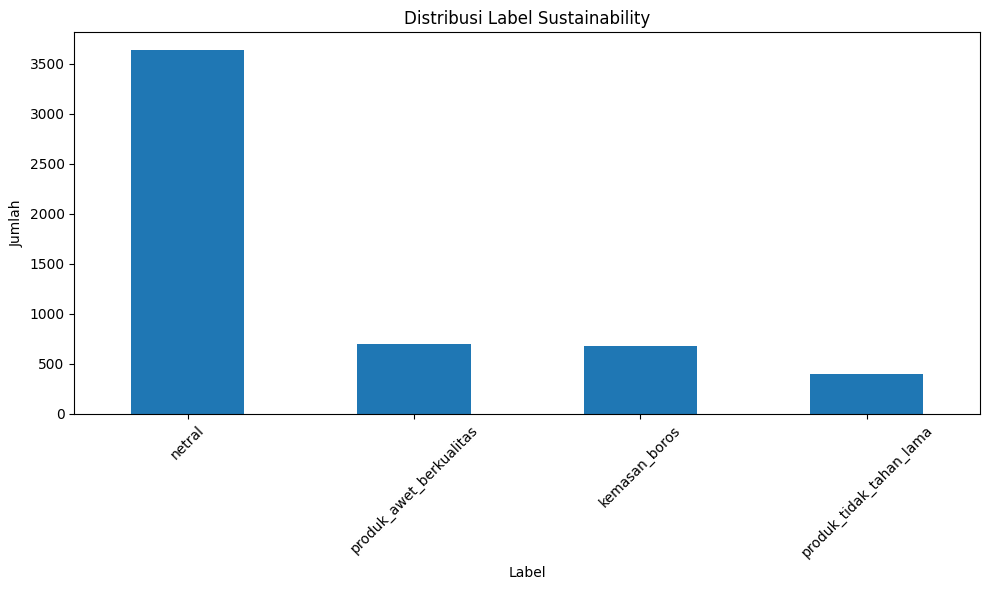


STEP 5: DATA BALANCING
Distribusi sebelum balancing:
sustainability_label
netral                     3631
produk_awet_berkualitas     694
kemasan_boros               676
produk_tidak_tahan_lama     399
Name: count, dtype: int64
Using RandomOverSampler

Distribusi setelah balancing:
sustainability_label
netral                     3631
produk_awet_berkualitas    2541
kemasan_boros              2541
produk_tidak_tahan_lama    2541
Name: count, dtype: int64

STEP 6: FEATURE ENGINEERING DENGAN TF-IDF
Creating TF-IDF features...
TF-IDF matrix shape: (11254, 3000)
Vocabulary size: 3000

Sample features: ['abis' 'abu' 'acak' 'acc' 'ad' 'ada' 'ada baik' 'ada cacat' 'ada dus'
 'ada kemas' 'ada kendala' 'ada konfirmasi' 'ada lecet' 'ada masalah'
 'ada patah' 'ada pecah' 'ada respon' 'ada rusa' 'ada rusak' 'ada segel']

STEP 7: MODEL TRAINING DAN COMPARISON

Training Naive Bayes...
Accuracy: 0.8561
F1-Score (macro): 0.8610

Training Logistic Regression...
Accuracy: 0.9480
F1-Score (macro): 0.9499

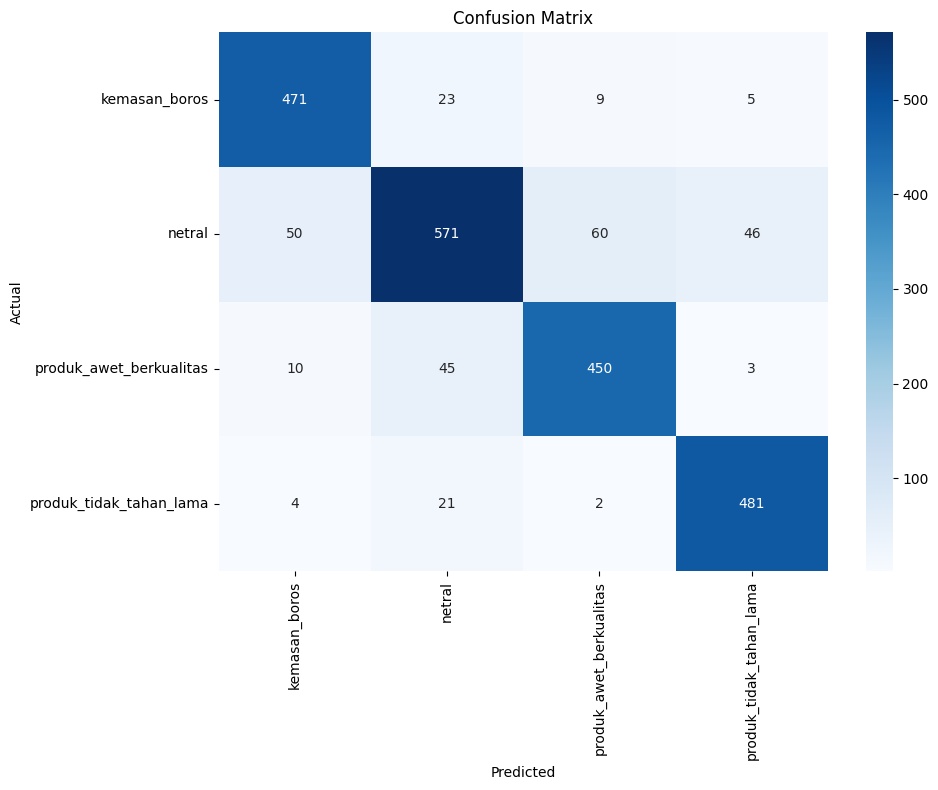


--- PER-CLASS ACCURACY ---
kemasan_boros: 0.9272
netral: 0.7854
produk_awet_berkualitas: 0.8858
produk_tidak_tahan_lama: 0.9469

STEP 9: FEATURE IMPORTANCE ANALYSIS

--- TOP FEATURES FOR KEMASAN_BOROS ---
packing: -3.8765
aman: -4.4916
cepat: -4.6608
barang: -4.6850
kirim: -4.6948
rapi: -4.7940
plastik: -4.7990
sesuai: -4.9036
kirim cepat: -4.9571
bagus: -4.9969
packingnya: -5.0508
bubble: -5.0812
kemas: -5.0850
packing aman: -5.1167
wrap: -5.1821
bungkus: -5.2426
terima: -5.2474
packing rapi: -5.2521
seller: -5.2852
baik: -5.3004

--- TOP FEATURES FOR NETRAL ---
sesuai: -4.3649
barang: -4.3703
kirim: -4.4649
bagus: -4.6873
nya: -4.8407
pesan: -4.9744
cepat: -4.9791
beli: -5.0878
produk: -5.1690
banget: -5.1778
warna: -5.1975
terima: -5.2281
baik: -5.2541
kecewa: -5.2617
pakai: -5.3085
kasih: -5.3385
harga: -5.3641
bahan: -5.3707
kurang: -5.4109
jual: -5.4421

--- TOP FEATURES FOR PRODUK_AWET_BERKUALITAS ---
mantap: -3.8010
banget: -4.3607
rekomendasi: -4.5303
barang: -4.5613
sesuai: 

In [ ]:
# =============================================================================
# EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Ganti dengan path ke file dataset Anda
    DATA_PATH = "/content/PRDECT-ID Dataset.csv"  # atau path ke PRDECT-ID dataset

    # Jalankan pipeline
    results = main_pipeline(DATA_PATH)

    print("\n" + "="*80)
    print("PROJECT COMPLETED SUCCESSFULLY!")
    print("="*80)
    print("\nFiles generated:")
    print("- sustainability_model_model.pkl (trained model)")
    print("- sustainability_model_vectorizer.pkl (TF-IDF vectorizer)")
    print("- sustainability_model_preprocessing.pkl (preprocessing info)")
    print("\nModel ready for deployment!")

In [ ]:
import pickle

# Ganti path dengan file model yang kamu miliki
with open("sustainability_model_model.pkl", "rb") as f:
    model = pickle.load(f)

print("Tipe model yang disimpan:", type(model))

Tipe model yang disimpan: <class 'sklearn.naive_bayes.MultinomialNB'>
